In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import tqdm
import pickle

import uncertainties as uct
from uncertainties import unumpy as unp

from scipy.optimize import curve_fit

# 1. Inverting Amplifier

### 1.1 Transfer curve by frequencies

In [ ]:

handle = open("inverting_amp_high.pkl", 'rb')
data_h=pickle.load(handle)
handle.close()

handle = open("inverting_amp_low.pkl", 'rb')
data_l=pickle.load(handle)
handle.close()

R1 = data_l["R1"]
freq = data_l["Freq"]
f = freq[6]

T, Ch1, Ch2 = data_l[f]
length = 100
T = T[:length]
Ch1 = Ch1[:length]
Ch2 = Ch2[:length]

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(T,Ch1,s=0.3,color="orange")
axs2.scatter(T,Ch2,s=0.3,color="blue")
axs3.scatter(Ch1,Ch2,s=0.3)

### 1.2. Transfer curve by resistances

[-0.29938357  0.0181863   1.          1.        ]
[-0.42796633  0.01757195  1.          1.        ]
[-0.63846743  0.0148932   1.          1.        ]
[-0.89108156  0.02925056  1.          1.        ]
[-0.96937022  0.04059007  1.          1.        ]
[-1.68589963e+00  3.82695550e-02  1.90000000e+03  1.90000000e+03]
[-1.86001887e+00  3.63514884e-02  1.90000000e+03  1.90000000e+03]
[-3.82942099e+00  7.22998710e-02  1.90000000e+03  1.90000000e+03]
[-9.12642470e+00  1.96031634e-01  1.90000000e+03  1.90000000e+03]
[-1.95323856e+01  4.69273807e-01  1.90000000e+03  1.90000000e+03]


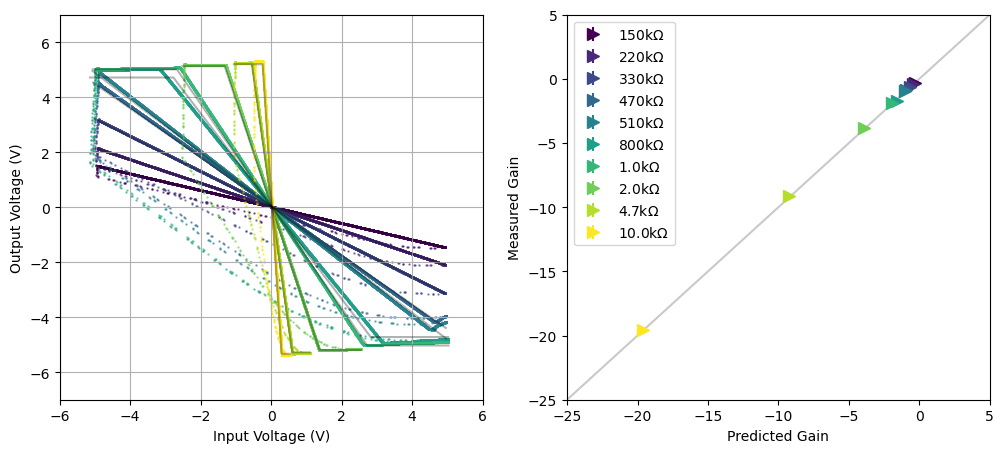

In [342]:
def linear(x,a,b):
    return a*x+b

def fit(x,a,b,reg1,reg2):
    reg1,reg2 = int(reg1),int(reg2)
    V1 = linear(x[reg1],a,b)
    y1 = np.full(reg1,V1)
    y2 = linear(x[reg1:-reg2],a,b)
    V2 = linear(x[-reg2],a,b)
    y3 = np.full(reg2,V2)
    y = np.concatenate((y1,y2,y3))
    return y

########## End of Function Defining ##########

fig = plt.figure(figsize=(12,5))
grid = gs.GridSpec(1,2)
axs1 = plt.subplot(grid[0])
axs2 = plt.subplot(grid[1])

handle = open("inverting_amp.pkl", 'rb')
data=pickle.load(handle)
handle.close()

R1 = data["R1"]
Res2 = data["R2"]
E_sat = 6

colours = plt.cm.viridis(np.linspace(0, 1, len(Res2)))

X = np.linspace(-30,10)
axs2.plot(X,X,color="black",alpha=0.01)

m_values = []
for i, R2 in enumerate(Res2):
    t,Vin,Vout = data[R2]
    
    # Vin = Vin[:200]
    # Vout = Vout[:200]
    # Sort time series by increasing Ch1 values. 
    indices = np.argsort(Vin) 
    Vin = Vin[indices]
    Vout = Vout[indices]

    E_sat = 6
    amp = -R2/R1
    trial = [amp,25e-6,1,1]
    if R2 >= 800:
        trial = [amp,25e-6,1900,1900]
    popt,pcov = curve_fit(fit,Vin,Vout,p0=trial,maxfev = 10800)
    print(popt)
    perr = np.sqrt(np.diag(pcov))
    m = -R2/R1
    axs1.plot(Vin,fit(Vin,*popt),color="black",alpha=0.3)
    if R2 >= 1000: 
        R2 /= 1000
        label = fr"{R2}k$\Omega$"
    else: label = fr"{R2}$\Omega$"
    axs1.scatter(Vin,Vout
                 ,s=0.5,alpha=0.6,color=colours[i]
                 )
    
    axs2.errorbar(m,popt[0]
                  ,label=fr"{R2}k$\Omega$"
                  ,yerr = perr[0]
                  ,fmt=">",markersize="9",color = colours[i]
                  )
axs2.legend(loc="upper left")
axs1.set_ylim(-7,7)
axs1.set_xlim(-6,6)
axs1.grid()
axs1.set_ylabel("Output Voltage (V)")
axs1.set_xlabel("Input Voltage (V)")

axs2.set_ylim(-25,5)
axs2.set_xlim(-25,5)
axs2.plot(X,X,color="black",alpha=0.2)
axs2.set_ylabel(r"Measured Gain")
axs2.set_xlabel(r"Predicted Gain")

fig.savefig("figures/inverting_slopes.png")

# Individual NICs

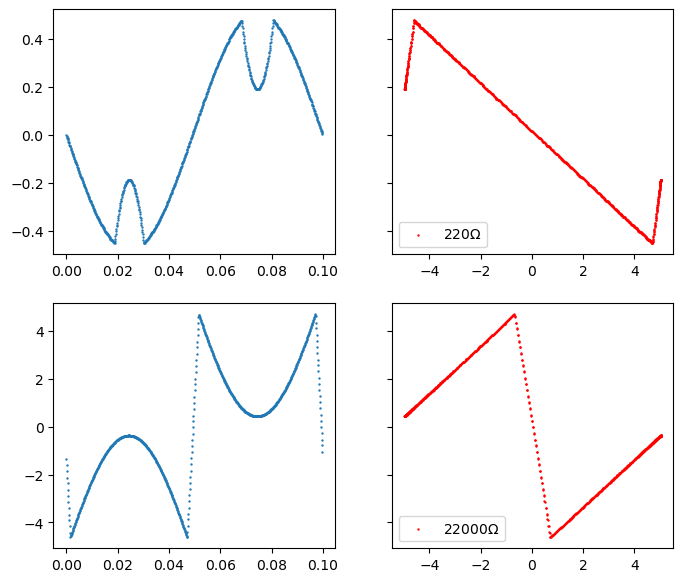

In [106]:
fig,axs = plt.subplots(2,2,figsize=(8,7),sharey="row")

handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

for i,R_i in enumerate([data["Res"][0],data["Res"][3]]):
    ax = axs[i]
    T,Ch1,Ch2 = data[R_i]
    
    fraction = round(len(T)/10) # Data points in one oscillation
    T = T[:fraction]; Ch1 = Ch1[:fraction]; Ch2 = Ch2[:fraction]
    
    ax[0].scatter(T,Ch2,s=0.5)
    ax[1].scatter(Ch1,Ch2,label=fr"{R_i}$\Omega$",s=0.5,color="red")
    ax[1].legend(loc="lower left")

Theory [-0.4517969662140368, 4.545454545454545, 5.457545454545455] 
 Fit [-0.4525136   3.33378381  4.63579955] [0.00013951 0.00678602 0.00047227]
Theory [-0.3016995456809503, 0.04545454545454545, 0.785608695652174] 
 Fit [-0.30399154  0.04506428  0.69672517] [1.50871003e-04 2.77465556e-06 2.96047671e-04]


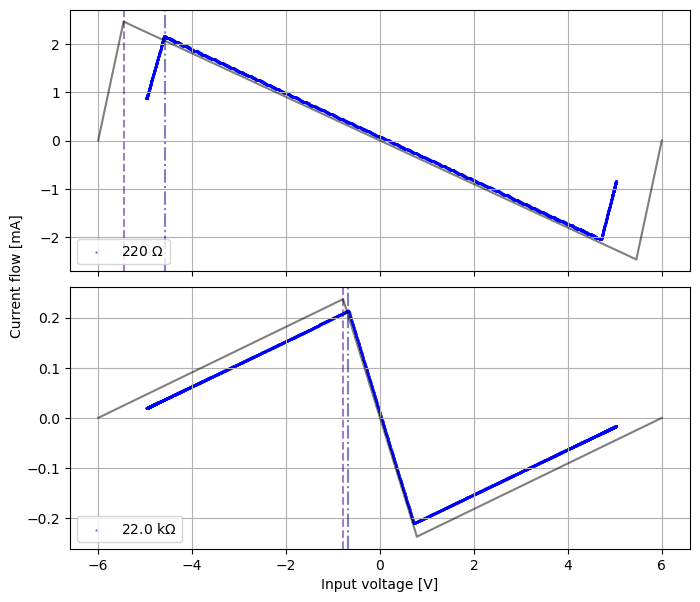

In [349]:
# Fitting 
def linear(x,a,b,c):
    return a*(x-b)+c

def fit(x,aint,aext,b,reg):
    reg = int(reg)
    c = b*aint
    y1 = linear(x[:reg],aext,-b,-c)
    y2 = linear(x[reg:-reg],aint,b,c)
    y3 = linear(x[-reg:],aext,b,c)

    return np.concatenate((y1,y2,y3))

########## End of Function Defining ##########

fig,axs = plt.subplots(2,1,figsize=(8,7),sharex=True)#,sharey=True)
fig.subplots_adjust(hspace=0.06)

handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

Vcc = data["Vcc"][0]
A = 2000

for i,R_i in enumerate([data["Res"][0],data["Res"][3]]):
    ax = axs[i]
    ax.grid()
    T,Ch1,Ch2 = data[R_i]
    Ch2 /= R_i/1000 # Convert to mA from the start to avoid headaches
    fraction = round(len(T)/10)

    # Split time series by cycle and fit PER cycle for error analysis.
    param = []
    for cycle in range(10):
        start = cycle*fraction
        final = (cycle+1)*fraction
        t = T[start:final]; ch1 = Ch1[start:final]; ch2 = Ch2[start:final]
        
        # Sort time series by increasing Ch1 values. 
        indices = np.argsort(ch1)
        ch1 = ch1[indices]; ch2 = ch2[indices]

        if i==0:
            R1,R2,R3 = data["Res"][:3]
            reg = round(len(t)/8)
        else: 
            R1,R2,R3 = data["Res"][3:]
            reg = round(len(t)/2.2)

        m_ext = 1/R1*1000
        m_int = ((1-A)*R2+R3)/(R1*(R2+(1+A)*R3))*1000
        # m_int= -R2/R1/R3
        b = (R2+(1+A)*R3)/(A*(R2+R3))*Vcc
        # b = R3/(R2+R3)*Vcc

        trial = [m_int,m_ext,b,reg]
        popt,_ = curve_fit(fit,ch1,ch2,p0=trial,maxfev = 2800)
        param.append(popt)
    popt = np.mean(param,axis=0)
    err = np.std(param,axis=0)
    print("Theory",trial[:3],"\n Fit",popt[:3],err[:3])

    X = np.linspace(-6,6,1000)
    split = int((6-b)/12*1000)
    ax.axvline(x=X[split],ls="dashed",color="indigo",alpha=0.5)
    ax.axvline(x=ch1[reg],ls="dashdot",color="darkblue",alpha=0.5)

    ax.plot(X,fit(X,*trial[:3],split),alpha=0.5,color="black")

    # X_exp = np.concatenate([np.linspace(-6,ch1[reg-1],100)
    #                     ,ch1
    #                     ,np.linspace(ch1[-reg+1],6,100)]
    #                     )

    # ax.scatter(X_exp,fit(X_exp,*popt[:3],reg+100),color="black",alpha=0.5,s=0.4)
    label = fr"{R_i/1000} k$\Omega$" if R_i==22000 else fr"{R_i} $\Omega$"
    ax.scatter(Ch1,Ch2,label=label,s=0.5,alpha=0.5,color="blue")
    ax.legend(loc="lower left")
axs[1].set_xlabel("Input voltage [V]")
fig.text(0.05, 0.5, 'Current flow [mA]', va='center', rotation='vertical')
fig.savefig("figures/NIC_curve.png")

[-0.45179696621403675+/-5.551115123125783e-17, 4.545454545454546+/-8.881784197001252e-16, 5.457545454545454+/-8.881784197001252e-16] []


TypeError: fit() missing 3 required positional arguments: 'aext', 'b', and 'reg'

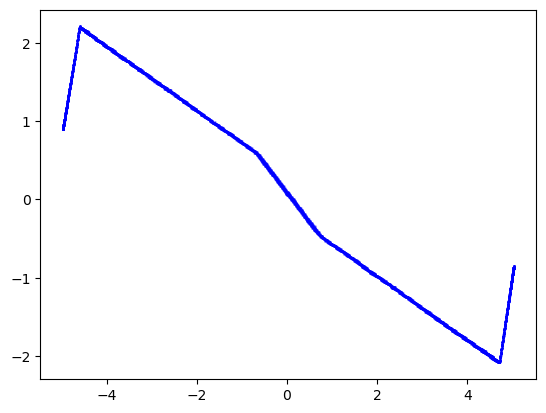

In [380]:
# Fitting 
def linear(x,a,b,c):
    return a*(x-b)+c

def fit(x,aint,aext,b,reg):
    reg = int(reg)
    c = b*aint
    y1 = linear(x[:reg],aext,-b,-c)
    y2 = linear(x[reg:-reg],aint,b,c)
    y3 = linear(x[-reg:],aext,b,c)

    return np.concatenate((y1,y2,y3))

########## End of Function Defining ##########

handle = open("NIC_transfer_curve.pkl", 'rb')
data=pickle.load(handle)
handle.close()

Vcc = data["Vcc"][0]
A = 2000

# Create empty arrays onto which each NIC will be added. 
T = np.full(len(data[220][0]),0.)
Ch1 = data[220][1]
Ch2 = np.full(len(data[220][0]),0.)

for R_i in [data["Res"][0],data["Res"][3]]:
    t,ch1,ch2 = data[R_i]
    T += t
    Ch2 += ch2/R_i*1000 # Convert to mA

plt.scatter(Ch1,Ch2,s=0.5,alpha=0.5,color="blue")

param = []
for i,R_i in enumerate([data["Res"][0],data["Res"][3]]):
    T,Ch1,Ch2 = data[R_i]
    Ch2 /= R_i/1000 # Convert to mA from the start to avoid headaches
    fraction = round(len(T)/10)

    # Split time series by cycle and fit PER cycle for error analysis.
    trial = []
    for cycle in range(10):
        start = cycle*fraction
        final = (cycle+1)*fraction
        t = T[start:final]; ch1 = Ch1[start:final]; ch2 = Ch2[start:final]
        
        # Sort time series by increasing Ch1 values. 
        indices = np.argsort(ch1)
        ch1 = ch1[indices]; ch2 = ch2[indices]

        if i==0:
            R1,R2,R3 = data["Res"][:3]
            reg = round(len(t)/8)
        else: 
            R1,R2,R3 = data["Res"][3:]
            reg = round(len(t)/2.2)

        m_ext = 1/R1*1000
        m_int = ((1-A)*R2+R3)/(R1*(R2+(1+A)*R3))*1000
        b = (R2+(1+A)*R3)/(A*(R2+R3))*Vcc

        trial.append([m_int,m_ext,b,reg])
    value = np.mean(trial,axis=0); error = np.std(trial,axis=0)
    param.append([uct.ufloat(i,j) for i,j in zip(value,error)])

X = np.linspace(-6,6,1000)
split = int((6-b)/12*1000)
print(param[0][:3],param[1][4:])
plt.plot(X,fit(X,*param[0][:3],split)+fit(X,*param[1][5:],split)
            ,alpha=0.5,color="black")

plt.axvline(x=X[split],ls="dashed",color="indigo",alpha=0.5)
plt.axvline(x=ch1[reg],ls="dashdot",color="darkblue",alpha=0.5)


plt.xlabel("Input voltage [V]"); plt.ylabel('Current flow [mA]')

plt.savefig("figures/Chua_characteristic.png")
